In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random

In [2]:
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

# Find failure probability 

In [5]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class PINN_m(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_m, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

class PINN_all(PINN_m):
    def forward(self, t, m, mu, k, y0, v0):
        x = torch.cat([t, m, mu, k, y0, v0], dim=1)
        return self.net(x)

# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Initialize training parameters
def initialize_uniform_mass(m_mean=1.0, m_std=0.1):
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = m_mean, m_std
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

def initialize_uniform_all():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    mu_mean, mu_std = 0.6, 0.1
    k_mean, k_std = 5.0, 0.5
    y0_mean, y0_std = -0.4, 0.1
    v0_mean, v0_std = 3.0, 0.5
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 4 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 2 * mu_std, mu_mean + 4 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k_coll = torch.FloatTensor(N, 1).uniform_(k_mean - 2 * k_std, k_mean + 4 * k_std)
    k_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    y0_coll = torch.FloatTensor(N, 1).uniform_(y0_mean - 2 * y0_std, y0_mean + 4 * y0_std)
    y0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    v0_coll = torch.FloatTensor(N, 1).uniform_(v0_mean - 2 * v0_std, v0_mean + 4 * v0_std)
    v0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0

def update_mass():
    pass

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001, lambda_bc=10.0):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = lambda_bc
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            
            # if epoch % 1000 == 0:
                 
            #     m_val = update_mass()

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)

## Finding MPP

### Uniformely distributed mass

Epoch 0, PDE loss: 0.09658359736204147, BC loss: 9.113851547241211


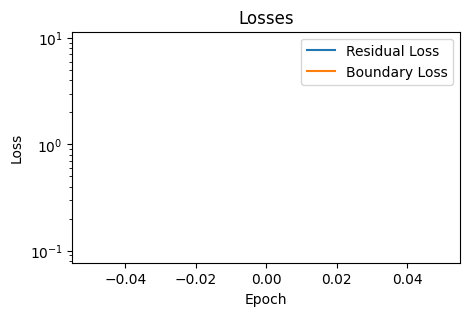

Epoch 1000, PDE loss: 0.1557406634092331, BC loss: 0.0002874687488656491


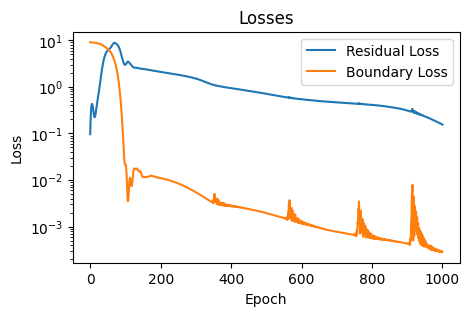

Epoch 2000, PDE loss: 0.03839625418186188, BC loss: 5.239417077973485e-05


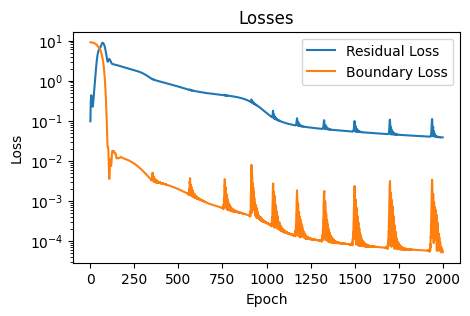

In [8]:
# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass()
mass_model = PINN_m(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(mass_model.parameters(), lr=0.001)
trainer = Trainer(mass_model, optimizer,epochs=2001)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)

In [35]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 10)
t_test = torch.linspace(0, 5, 10).view(-1, 1)

y_pred = []
for idx, m in enumerate(m_values):
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred.append(mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val))

print(y_pred)

min_values = [torch.min(pred).item() for pred in y_pred]
print(min_values)
# Find the three min_values closest to -1.0
closest_min_values = sorted(min_values, key=lambda x: abs(x + 1))[:3]

# Find the corresponding masses
closest_masses = [m_values[min_values.index(val)] for val in closest_min_values]

print("Closest min values to -1.0:", closest_min_values)
print("Corresponding masses:", closest_masses)

[tensor([[-0.4093],
        [ 0.8622],
        [ 0.6268],
        [-0.3244],
        [-0.5645],
        [-0.0396],
        [ 0.3619],
        [ 0.2310],
        [-0.1606],
        [-0.4190]], grad_fn=<AddmmBackward0>), tensor([[-0.4061],
        [ 0.9014],
        [ 0.7450],
        [-0.2522],
        [-0.6583],
        [-0.1842],
        [ 0.3438],
        [ 0.3502],
        [-0.0292],
        [-0.3504]], grad_fn=<AddmmBackward0>), tensor([[-0.4036],
        [ 0.9351],
        [ 0.8607],
        [-0.1574],
        [-0.7235],
        [-0.3438],
        [ 0.2811],
        [ 0.4416],
        [ 0.1130],
        [-0.2640]], grad_fn=<AddmmBackward0>), tensor([[-0.4017],
        [ 0.9635],
        [ 0.9715],
        [-0.0446],
        [-0.7565],
        [-0.5052],
        [ 0.1766],
        [ 0.4965],
        [ 0.2578],
        [-0.1583]], grad_fn=<AddmmBackward0>), tensor([[-0.4004],
        [ 0.9870],
        [ 1.0755],
        [ 0.0813],
        [-0.7563],
        [-0.6560],
        [ 0.0

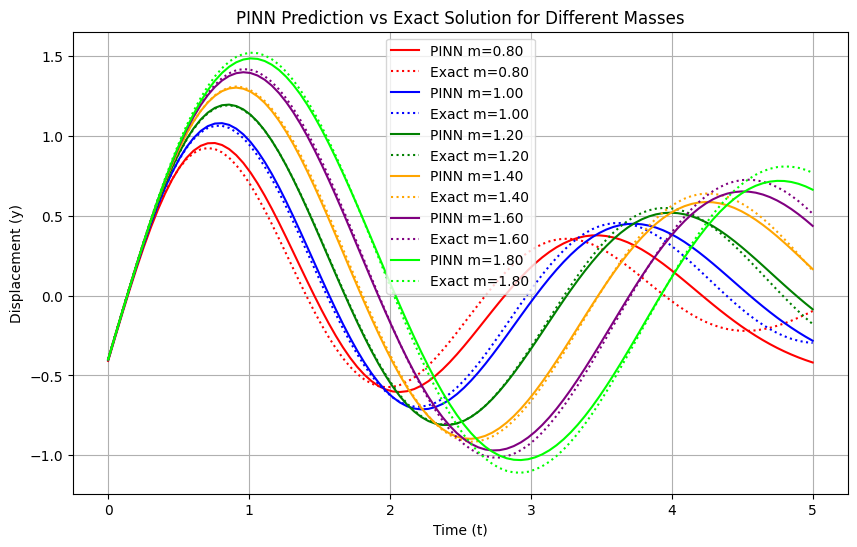

Mass = 0.80, MSE = 0.012735
Mass = 1.00, MSE = 0.003354
Mass = 1.20, MSE = 0.000807
Mass = 1.40, MSE = 0.000570
Mass = 1.60, MSE = 0.001397
Mass = 1.80, MSE = 0.002268

Combined Mean Squared Error over all masses: 0.003522


In [18]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

# Compute and print error metrics for different masses
errors = []
for m in m_values:
    m_test_current = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred_current = mass_model(t_test, m_test_current, mu_val, k_val, y0_val, v0_val)
    y_exact_current = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    mse_current = np.mean((y_pred_current.detach().numpy() - y_exact_current)**2)
    errors.append(mse_current)
    print(f"Mass = {m:.2f}, MSE = {mse_current:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all masses: {combined_mse:.6f}")

Mass = 0.80, MSE = 0.012735
Mass = 1.00, MSE = 0.003354
Mass = 1.20, MSE = 0.000807
Mass = 1.40, MSE = 0.000570
Mass = 1.60, MSE = 0.001397
Mass = 1.80, MSE = 0.002268

Combined Mean Squared Error over all masses: 0.003522